# Mice sleep

## Data reading

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper



In [11]:
# The file is made up of the following structure:
# state : char (1 byte)
# bin : array[0..400] of single (array of 401 floats (4 bytes each))
# EEGv,EMGv,temp : single (4 bytes each)
# Make a pandas dataframe with the data with appropriate column names
# Create a dtype with the binary data format and the desired column names

# Read all the .smo files in the data folder
train_files = glob.glob('data/*.smo')
test_files = glob.glob('data/test/*.smo')

state_mapping = {
    b'w': 'w', b'1': 'w', b'4': 'w',
    b'n': 'n', b'2': 'n', b'5': 'n',
    b'r': 'r', b'3': 'r', b'6': 'r'
}


def fix_state(dataframe):
    dataframe['state'] = dataframe['state'].map(state_mapping)
    # Change state to 'x' if it is not one of the 3 states
    dataframe = dataframe.dropna()
    return dataframe

def load_file(file_path):
    dt = [('state', 'a1')]
    for i in range(401):
        dt.append(('bin' + str(i), 'f4'))
    dt.append(('EEGv', 'f4'))
    dt.append(('EMGv', 'f4'))
    dt.append(('temp', 'f4'))
    dt = np.dtype(dt)
    data = np.fromfile(file_path, dtype=dt)
    #data = np.fromfile(files[0], dtype=dt)
    df = pd.DataFrame.from_records(data[:int(len(data)/2)])
    print(df['state'].value_counts())
    fix_state(df)
    return df

def load_files(files):
    dt = [('state', 'a1')]
    for i in range(401):
        dt.append(('bin' + str(i), 'f4'))
    dt.append(('EEGv', 'f4'))
    dt.append(('EMGv', 'f4'))
    dt.append(('temp', 'f4'))
    dt = np.dtype(dt)
    data = np.concatenate( [np.fromfile(file, dtype=dt) for file in files] )
    #data = np.fromfile(files[0], dtype=dt)
    df = pd.DataFrame.from_records(data[:int(len(data)/2)])
    fix_state(df)
    # Keep only the first 2 out of 4 days of data
    return df

def balance_classes(df):
    # Get the value counts of each class
    class_counts = df['state'].value_counts()

    # Get the majority class
    minority_class = class_counts.idxmin()

    minority_count = class_counts[minority_class]

    # Get all other classes
    df_balanced = df[df['state'] == minority_class]

    classes = class_counts.index.tolist()
    classes.remove(minority_class)
    for cls in classes:
        df_balanced = pd.concat([df_balanced, df[df['state'] == cls].sample(minority_count)])


    # Combine the oversampled minority classes with the majority class

    return df_balanced


## Separation, Normalization/preprocessing, Feature Selection

# Data Visualization

b'w'    20952
b'n'    19713
b'r'     2502
b'3'       17
b'2'        8
b'1'        8
Name: state, dtype: int64


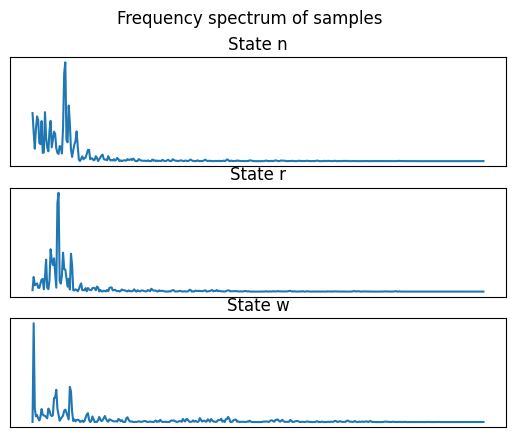

In [12]:
df = load_file(train_files[4])

states = df['state'].unique()
# Pick a sample for each possible state
samples = []
for i in states:
    samples.append(df[df['state'] == i].sample(1))

# Plot the samples frequency spectrum in a grid
# Disable axis numbers and ticks
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False
fig, axs = plt.subplots(3, 1)
fig.suptitle('Frequency spectrum of samples')
from itertools import product

subplot_indices = list(product(range(3), range(1)))
for i, sample in enumerate(samples):
    subplot_index = subplot_indices[i]
    axs[subplot_index[0]].plot(sample.iloc[:, 1:401].mean())
    axs[subplot_index[0]].set_title('State ' + str(sample['state'].iloc[0]))
plt.show()




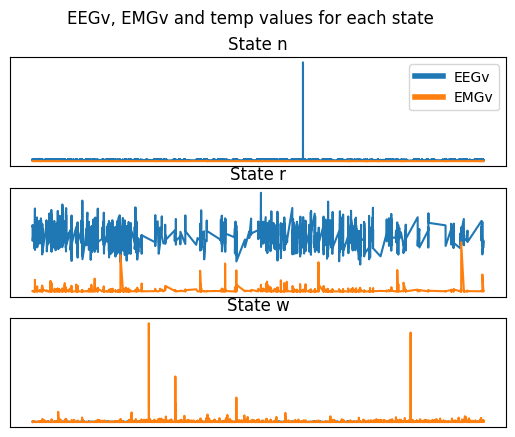

In [13]:
# Plot the possible values for EEGv, EMGv and temp values for each state

# Disable axis numbers and ticks
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False
fig, axs = plt.subplots(3, 1)
fig.suptitle('EEGv, EMGv and temp values for each state')
from itertools import product

subplot_indices = list(product(range(3), range(1)))
for i, state in enumerate(states):
    subplot_index = subplot_indices[i]
    axs[subplot_index[0]].plot(df[df['state'] == state]['EEGv'])
    axs[subplot_index[0]].plot(df[df['state'] == state]['EMGv'])
    # Temp is always at 0
    # axs[subplot_index[0], subplot_index[1]].plot(df[df['state'] == state]['temp'])
    axs[subplot_index[0]].set_title('State ' + str(state))

# Add a legend for the colors
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='tab:blue', lw=4),
                Line2D([0], [0], color='tab:orange', lw=4)]
axs[0].legend(custom_lines, ['EEGv', 'EMGv'])


plt.show()




# Normalization

In [14]:
one_hot_mapping = {'w': np.array([0,0,1]),
                 'n': np.array([0,1,0]),
                 'r': np.array([1,0,0])}

def normalize(df):
    normalized_df = balance_classes(df)
    # EEGv
    min_value = df['EEGv'].min()
    max_value = df['EEGv'].max()
    normalized_df['EEGv'] = (df['EEGv'] - min_value) / (max_value - min_value)

    # EMGv
    min_value = df['EMGv'].min()
    max_value = df['EMGv'].max()
    normalized_df['EMGv'] = (df['EMGv'] - min_value) / (max_value - min_value)
    for i in range(401):
            min_value = df['bin' + str(i)].min()
            max_value = df['bin' + str(i)].max()
            normalized_df['bin' + str(i)] = (df['bin' + str(i)] - min_value) / (max_value - min_value)

    # Drop temp column and upper half of bin columns
    normalized_df = normalized_df.drop(['temp'], axis=1)
    normalized_df = normalized_df.drop(normalized_df.iloc[:, 201:401], axis=1)
    
    # state
    normalized_df['state'] = df['state'].map(one_hot_mapping)

    return normalized_df

def split_data(data):
    return (data.drop('state', axis=1), data['state'])


## Model building

### Model Neural Network

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from keras.utils import np_utils
from keras.optimizers import RMSprop, Adam


def build_model(class_num=3, input_dim=203):
  model = Sequential()
  optimizer = Adam(learning_rate=0.0015)
  model.add(Dense(80, input_dim=input_dim, activation='softmax'))
  model.add(Dense(30, activation='softmax'))
  model.add(Dense(15, activation='softmax'))
  model.add(Dense(10, activation='softmax'))
  model.add(Dropout(0.2))
  model.add(Dense(class_num, activation='softmax'))

  # Compile the model
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

def save_model(model, model_name):
  model.save(model_name)
  print('Model saved as ' + model_name)

def load_model(model_name):
  model = tf.keras.models.load_model(model_name)
  print('Model loaded from ' + model_name)
  return model

def train_model(model, X_train, y_train, epochs=100, batch_size=10):
  model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

def predict(model, X_test):
  y_pred = model.predict(X_test)
  return y_pred

## Execution

In [16]:
# Get the list of all the files
# Shuffle it
# Pick out 20 files at a time
# Load, normalize, train
# Save the model
# Repeat until all files are used
import random

# Shuffle train_files
training_files = train_files
random.shuffle(training_files)

model = build_model()
save_model(model, 'models/model' + str(0) + '.h5')

# Pick out 20 files at a time
step = 20
for i in range(0, len(training_files), step):
  print("Training with files from " + str(i) + " to " + str(i+step))
  start = i
  end = i+step
  if end > len(training_files):
    end = len(training_files) - 1
  data = load_files(training_files[start:end])
  data = normalize(data)
  data = data.sample(frac=1)
  X_train, y_train = split_data(data)
  print("\tLoaded, Normalized, Split data")
  y_train = np.stack(y_train,axis=0)
  train_model(model, X_train, y_train, epochs=100, batch_size=int(len(X_train)/50))
  save_model(model, 'models/model' + str(i) + '.h5')
  



Model saved as models/model0.h5
Training with files from 0 to 20
	Loaded, Normalized, Split data
Epoch 1/100
51/51 [==============================] - 1s 8ms/step - loss: 1.1002 - accuracy: 0.3344
Epoch 2/100
51/51 [==============================] - 0s 8ms/step - loss: 1.0999 - accuracy: 0.3348
Epoch 3/100
51/51 [==============================] - 0s 8ms/step - loss: 1.0998 - accuracy: 0.3326
Epoch 4/100
51/51 [==============================] - 0s 8ms/step - loss: 1.0996 - accuracy: 0.3320
Epoch 5/100
51/51 [==============================] - 0s 8ms/step - loss: 1.0997 - accuracy: 0.3327
Epoch 6/100
51/51 [==============================] - 0s 8ms/step - loss: 1.0995 - accuracy: 0.3332
Epoch 7/100
51/51 [==============================] - 0s 8ms/step - loss: 1.0996 - accuracy: 0.3318
Epoch 8/100
51/51 [==============================] - 0s 8ms/step - loss: 1.0997 - accuracy: 0.3311
Epoch 9/100
51/51 [==============================] - 0s 8ms/step - loss: 1.0995 - accuracy: 0.3319
Epoch 10/100

# Evaluation

In [17]:

loaded_model = load_model('models/model120.h5')

# Test
test_data = load_files(test_files)
test_data = normalize(test_data)
test_data = test_data.sample(frac=1)

X_test, y_test = split_data(test_data)
y_test = np.stack(y_test,axis=0)

# Predict
y_pred = predict(loaded_model, X_test)


Model loaded from models/model120.h5
11011/11011 [==============================] - 10s 828us/step


Test loss: 1.0986121892929077
Test accuracy: 0.3333333432674408
Test F1 score: 0.16666666666666666


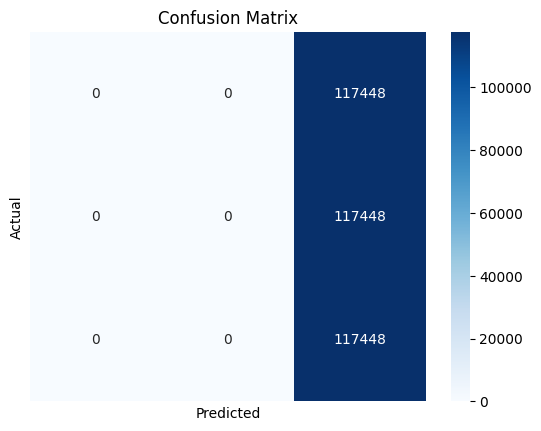

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


prediction = y_pred.argmax(axis=1)
test = y_test.argmax(axis=1)

# Evaluate
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
f1 = f1_score(test, prediction, average='macro')
print('Test F1 score:', f1)

# Create the confusion matrix
cm = confusion_matrix(test, prediction)

# Create the heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


# Prediction by Genome

In [19]:
# Group training files by genome

groups = {}

for file in training_files:
  genome = file.split("\\")[-1][0:3]
  if genome not in groups:
    groups[genome] = []
  groups[genome].append(file)

# Pick the N groups with the most files
N = 12
groups = dict(sorted(groups.items(), key=lambda item: len(item[1]), reverse=True)[:N])


for group in groups:
  print(group, ":", len(groups[group]), "mice")


029 : 6 mice
081 : 5 mice
29T : 5 mice
073 : 5 mice
032 : 5 mice
083 : 5 mice
051 : 5 mice
064 : 5 mice
043 : 5 mice
075 : 5 mice
056 : 5 mice
087 : 5 mice


## Training with a single mouse

In [20]:
models = {}

for group in groups:
  file = groups[group][0]
  print("Training with " + file)
  data = load_file(file)
  data = normalize(data)
  data = data.sample(frac=1)
  X_train, y_train = split_data(data)
  print("\tLoaded, Normalized, and Split data")
  y_train = np.stack(y_train,axis=0)
  print(X_train.shape)
  print(y_train.shape)
  train_model(model, X_train, y_train, epochs=100, batch_size=int(len(X_train)/50))
  print("Genome " + group + " trained")
  models[group] = model
  


Training with data\02903.smo
b'n'    21113
b'w'    19824
b'r'     2188
b'2'       39
b'1'       26
b'3'       10
Name: state, dtype: int64
	Loaded, Normalized, and Split data
(6594, 203)
(6594, 3)
Epoch 1/100
51/51 [==============================] - 0s 2ms/step - loss: 1.0988 - accuracy: 0.3308
Epoch 2/100
51/51 [==============================] - 0s 2ms/step - loss: 1.0988 - accuracy: 0.3320
Epoch 3/100
51/51 [==============================] - 0s 2ms/step - loss: 1.0989 - accuracy: 0.3297
Epoch 4/100
51/51 [==============================] - 0s 2ms/step - loss: 1.0990 - accuracy: 0.3345
Epoch 5/100
51/51 [==============================] - 0s 2ms/step - loss: 1.0990 - accuracy: 0.3358
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 1.0989 - accuracy: 0.3256
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 1.0988 - accuracy: 0.3330
Epoch 8/100
51/51 [==============================] - 0s 2ms/step - loss: 1.0987 - accuracy: 0.3329
Epoch 9/100

# Evaluation

{'029': ['data\\02903.smo', 'data\\02901.smo', 'data\\02908.smo', 'data\\02907.smo', 'data\\02910.smo', 'data\\02909.smo'], '081': ['data\\08102.smo', 'data\\08112.smo', 'data\\08113.smo', 'data\\08106.smo', 'data\\08103.smo'], '29T': ['data\\29T09.smo', 'data\\29T08.smo', 'data\\29T01.smo', 'data\\29T05.smo', 'data\\29T11.smo'], '073': ['data\\07302.smo', 'data\\07304.smo', 'data\\07306.smo', 'data\\07303.smo', 'data\\07301.smo'], '032': ['data\\03208.smo', 'data\\03206.smo', 'data\\03204.smo', 'data\\03201.smo', 'data\\03205.smo'], '083': ['data\\08314.smo', 'data\\08312.smo', 'data\\08305.smo', 'data\\08313.smo', 'data\\08311.smo'], '051': ['data\\05102.smo', 'data\\05107.smo', 'data\\05101.smo', 'data\\051G9.smo', 'data\\05108.smo'], '064': ['data\\06407.smo', 'data\\06403.smo', 'data\\06408.smo', 'data\\06404.smo', 'data\\06410.smo'], '043': ['data\\04308.smo', 'data\\043S5.smo', 'data\\04306.smo', 'data\\04304.smo', 'data\\04310.smo'], '075': ['data\\07502.smo', 'data\\07503.smo'

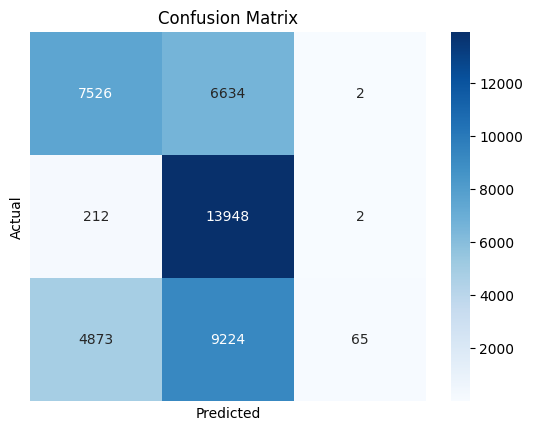

Test loss: 2.1190779209136963
Test accuracy: 0.4781855046749115
1298/1298 [==============================] - 1s 825us/step
[0 1 0]
Test F1 score: 0.4146273292015248


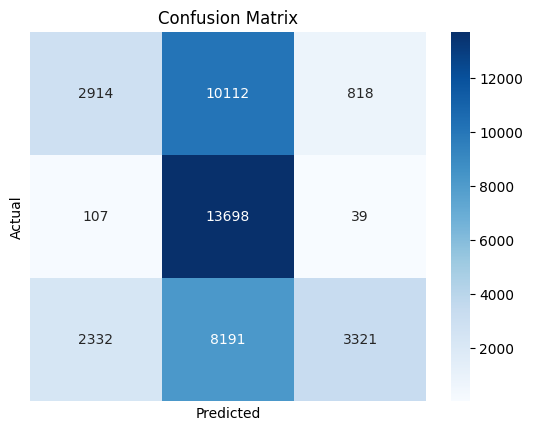

Test loss: 2.34751033782959
Test accuracy: 0.41707682609558105
858/858 [==============================] - 1s 824us/step
[0 1 0]
Test F1 score: 0.30748415164447107


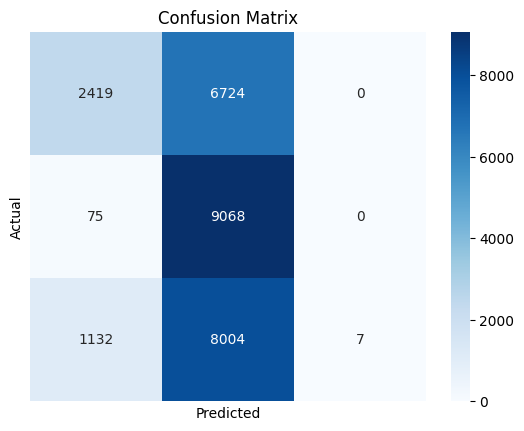

Test loss: 1.5508917570114136
Test accuracy: 0.48451730608940125
1339/1339 [==============================] - 1s 815us/step
[0 1 0]
Test F1 score: 0.3788432442624467


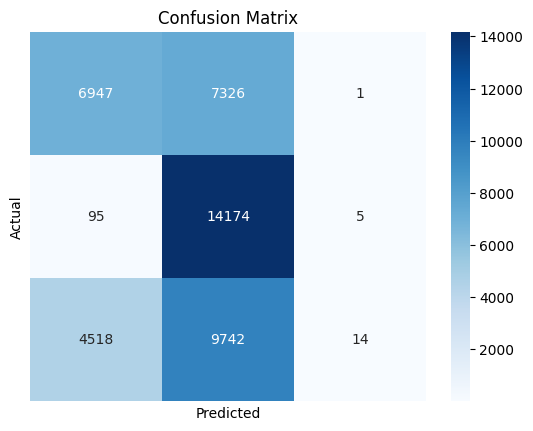

Test loss: 2.5380725860595703
Test accuracy: 0.35343894362449646
1385/1385 [==============================] - 1s 906us/step
[0 1 0]
Test F1 score: 0.20819649455791553


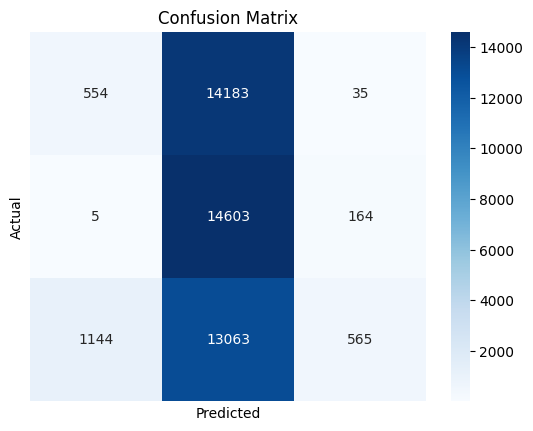

Test loss: 1.4238799810409546
Test accuracy: 0.48202213644981384
1105/1105 [==============================] - 1s 909us/step
[0 1 0]
Test F1 score: 0.3751716183774234


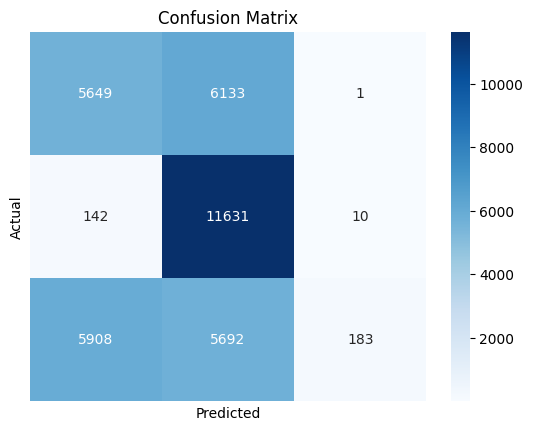

Test loss: 1.4943583011627197
Test accuracy: 0.4502856433391571
1220/1220 [==============================] - 1s 1ms/step
[0 1 0]
Test F1 score: 0.35018610160867736


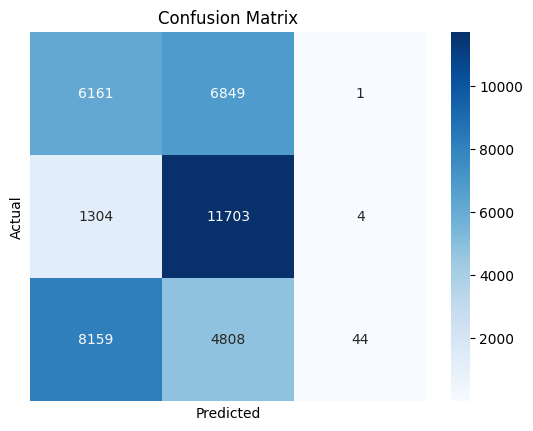

Test loss: 1.4984495639801025
Test accuracy: 0.4643082320690155
1140/1140 [==============================] - 1s 1ms/step
[1 0 0]
Test F1 score: 0.36324109203028376


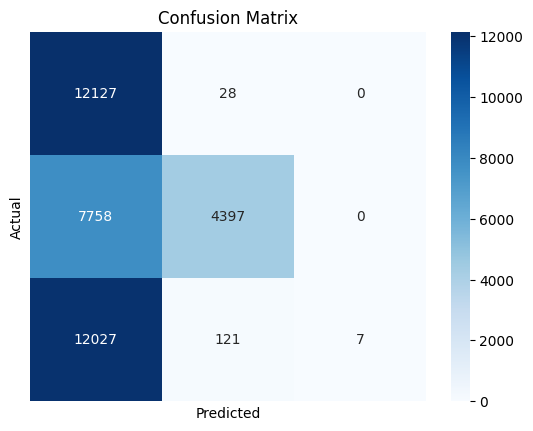

Test loss: 1.7995060682296753
Test accuracy: 0.3789677321910858
1051/1051 [==============================] - 1s 947us/step
[1 0 0]
Test F1 score: 0.24595750084120852


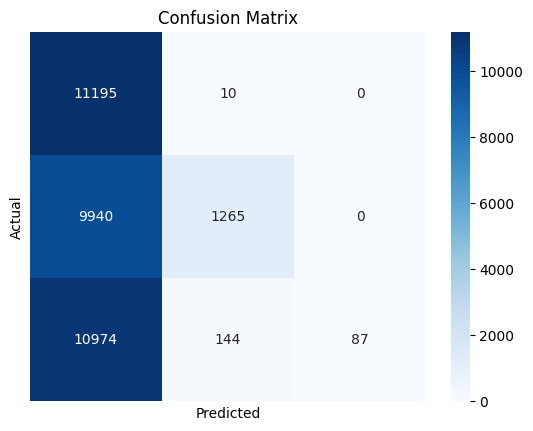

Test loss: 1.9725340604782104
Test accuracy: 0.3484872877597809
1168/1168 [==============================] - 1s 928us/step
[1 0 0]
Test F1 score: 0.19412958676418782


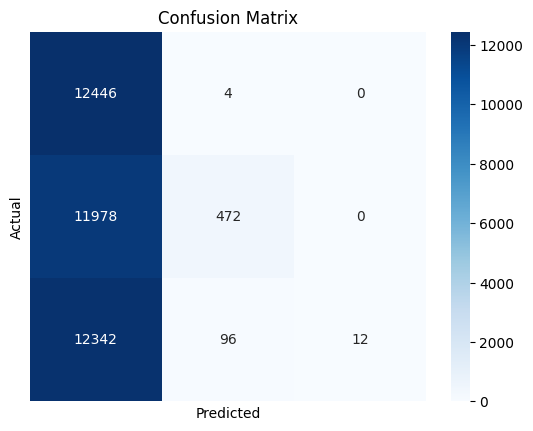

Test loss: 1.2917627096176147
Test accuracy: 0.5375884175300598
1118/1118 [==============================] - 1s 880us/step
[0 0 0]
Test F1 score: 0.42991435475670686


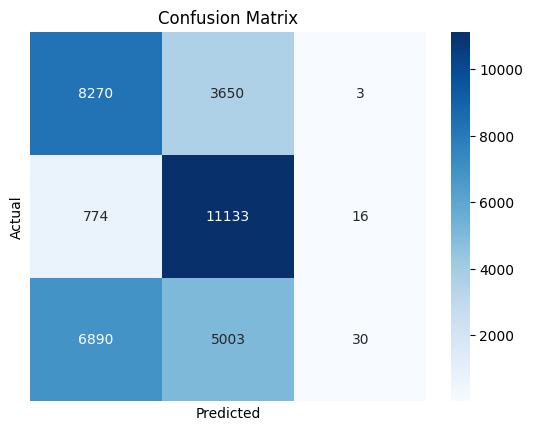

Test loss: 2.32926869392395
Test accuracy: 0.38150107860565186
1205/1205 [==============================] - 1s 844us/step
[0 1 0]
Test F1 score: 0.2519938408673647


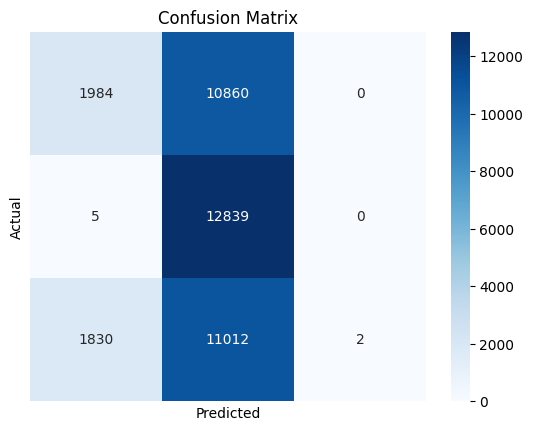

In [21]:
# Tests have to be on the same genome
# Get the mice from the same genomes

test_groups = {}
for g in groups:
  test_groups[g] = []
  for file in groups[g]:
    genome = file.split("\\")[-1][0:3]
    if genome == g:
      test_groups[g].append(file)

print(test_groups)

for k in models:
  data = load_files(test_groups[k])
  data = normalize(data)
  X_test, y_test = split_data(data)
  y_test = np.stack(y_test,axis=0)
  
  model = models[k]
  score = model.evaluate(X_test, y_test, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])
  y_pred = predict(model, X_test)
  y_pred = (y_pred > 0.5).astype(int)
  print(y_pred[0])
  f1 = f1_score(y_test, y_pred, average='macro')
  print('Test F1 score:', f1)
  cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
  # Create the heatmap
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
  # Add labels and title
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  # Show the plot
  plt.show()

# Prediction for a Single Mouse

Training with data\07108.smo
b'w'    20583
b'n'    20266
b'r'     2249
b'3'       62
b'1'       23
b'2'       17
Name: state, dtype: int64
	Loaded, Normalized, and Split data
(6933, 203)
(6933, 3)
Epoch 1/100
51/51 [==============================] - 0s 3ms/step - loss: 2.3458 - accuracy: 0.4065
Epoch 2/100
51/51 [==============================] - 0s 2ms/step - loss: 0.9879 - accuracy: 0.5569
Epoch 3/100
51/51 [==============================] - 0s 2ms/step - loss: 0.7157 - accuracy: 0.6912
Epoch 4/100
51/51 [==============================] - 0s 2ms/step - loss: 0.6653 - accuracy: 0.7147
Epoch 5/100
51/51 [==============================] - 0s 2ms/step - loss: 0.6403 - accuracy: 0.7373
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 0.6095 - accuracy: 0.7643
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 0.6017 - accuracy: 0.7710
Epoch 8/100
51/51 [==============================] - 0s 2ms/step - loss: 0.5894 - accuracy: 0.7795
Epoch 9/100

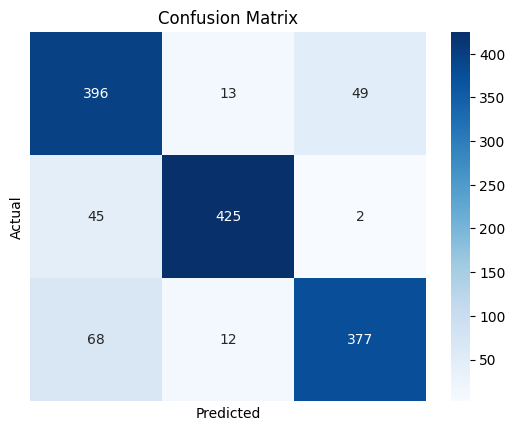

Training with data\08406.smo
b'w'    21095
b'n'    18923
b'r'     3111
b'1'       48
b'2'       22
b'3'        1
Name: state, dtype: int64
	Loaded, Normalized, and Split data
(9336, 203)
(9336, 3)
Epoch 1/100
51/51 [==============================] - 0s 2ms/step - loss: 1.5916 - accuracy: 0.4905
Epoch 2/100
51/51 [==============================] - 0s 2ms/step - loss: 0.8732 - accuracy: 0.5855
Epoch 3/100
51/51 [==============================] - 0s 2ms/step - loss: 0.8118 - accuracy: 0.6563
Epoch 4/100
51/51 [==============================] - 0s 2ms/step - loss: 0.7732 - accuracy: 0.6703
Epoch 5/100
51/51 [==============================] - 0s 2ms/step - loss: 0.7559 - accuracy: 0.6848
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 0.7451 - accuracy: 0.6945
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 0.7256 - accuracy: 0.7067
Epoch 8/100
51/51 [==============================] - 0s 2ms/step - loss: 0.6969 - accuracy: 0.7150
Epoch 9/100

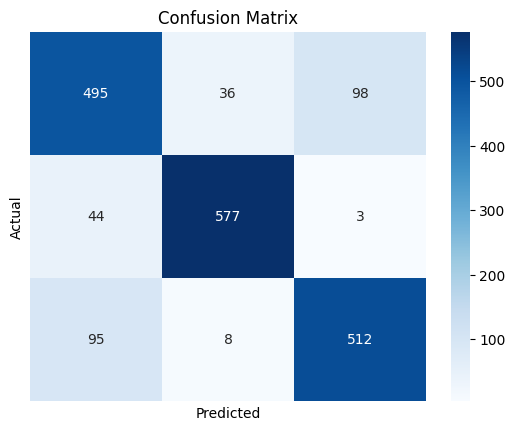

Training with data\06407.smo
b'w'    22981
b'n'    17718
b'r'     2312
b'2'       94
b'1'       68
b'3'       27
Name: state, dtype: int64
	Loaded, Normalized, and Split data
(7017, 203)
(7017, 3)
Epoch 1/100
51/51 [==============================] - 0s 2ms/step - loss: 1.0471 - accuracy: 0.6397
Epoch 2/100
51/51 [==============================] - 0s 2ms/step - loss: 0.5912 - accuracy: 0.7509
Epoch 3/100
51/51 [==============================] - 0s 2ms/step - loss: 0.5659 - accuracy: 0.7589
Epoch 4/100
51/51 [==============================] - 0s 2ms/step - loss: 0.5447 - accuracy: 0.7754
Epoch 5/100
51/51 [==============================] - 0s 2ms/step - loss: 0.5306 - accuracy: 0.7808
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 0.5211 - accuracy: 0.7915
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 0.5199 - accuracy: 0.7889
Epoch 8/100
51/51 [==============================] - 0s 2ms/step - loss: 0.5093 - accuracy: 0.8012
Epoch 9/100

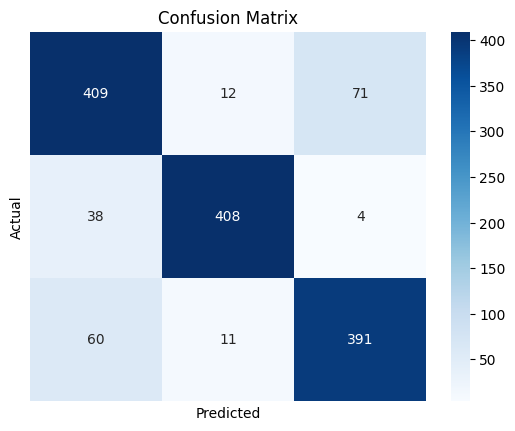

In [22]:
# Open mouse files one by one, train on part of the data, test on the rest
N = 3
for i in range(3):
    # Grab a random file
    file = random.choice(train_files)
    print("Training with " + file)
    data = load_file(file)
    data = normalize(data)
    data = data.sample(frac=1)

    # Grab 80% of the data for training
    X_train, y_train = split_data(data[:int(len(data)*0.8)])

    # Grab the rest for testing
    X_test, y_test = split_data(data[int(len(data)*0.8):])

    X_train, y_train = split_data(data)
    print("\tLoaded, Normalized, and Split data")
    y_train = np.stack(y_train,axis=0)
    print(X_train.shape)
    print(y_train.shape)
    train_model(model, X_train, y_train, epochs=100, batch_size=int(len(X_train)/50))

    # Test on the rest of the data
    y_test = np.stack(y_test,axis=0)
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    y_pred = predict(model, X_test)
    y_pred = (y_pred > 0.5).astype(int)
    f1 = f1_score(y_test, y_pred, average='macro')
    print('Test F1 score:', f1)

    cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    # Create the heatmap
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    # Add labels and title
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    # Show the plot
    plt.show()


